###  Data Entries: 
0 Bound, 1 Date + Time, 2 Seq No, 3 Lane, 4 Speed, 5 Class, 6 No of Axle, [ Axle Weight, Axle Spacing]

---
### <span style="color:red"> Methods and Procedures </span>


#### Data Cleaning
- Sort the data based on Date > Bound > lane   DONE
- obtain the gap distance    DONE

#### Fitting and Regression
- Find the daily average vehicle flow  DONE
- Find the Variation in Traffic flow across different times of the day DONE
- Find the variation in LDV:HDV ratio across different times of the day  GAVE UP
- Find the variation in (Traffic Volume in hour)/(Traffic Volume in day) across different times of the day [Reference](https://medium.com/hal24k-techblog/a-guide-to-generating-probability-distributions-with-neural-networks-ffc4efacd6a4) 
- Find the PDF of the vehicle weight of LDV  DONE 
- Find the PDF of the vehicle weight of HDV  DONE
- Find the Relation between parameters with the below methods  

#### Monte Carlo Simluation
- Set up an environment for simulation. Refer to your IR. 
- Run for 2400 years
- Obtain max load effect. -> Transition to SAP2000

---

### Relationship between each entries: 
 - Time of the day -> Proportion of Vehicle Class
   - Vehicle Class -> Vehicle Speed ? Need to see if there is a relationship or not. 
      - Vehicle Class + Vehicle Speed -> Gap Distance  
        //
   - Vehicle Class -> Axle Number 
      - Axle number -> Total Weight & Axle Weight

Multiple Lasso/Ridge Regression or polynomial regression would be used to draw the relationships of the above figures. 

### Assumptions and Relationships: 
- the Traffic composition relates to the time of the day
- Gap distance between vehicles is determined by the vehicle speed and the vehicle class ie. weight

In [130]:
import pandas as pd
import seaborn as sns

In [131]:
all_data= pd.read_excel('output.xlsx')
# usecols='A:I'

In [132]:
# all_data.loc[:,'Seq No':'Class'].head()
all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])
all_data['Date'] = pd.to_datetime(all_data['Date + Time']).dt.date
all_data['Date'].unique()

/var/folders/py/yncddnwd6kn7d9dzfmz1kcbm0000gn/T/ipykernel_56758/686523372.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])


array([datetime.date(2000, 8, 23), datetime.date(2000, 11, 21),
       datetime.date(2000, 11, 22), datetime.date(2004, 12, 30),
       datetime.date(2000, 1, 1)], dtype=object)

In [133]:
all_data = all_data.sort_values(['Date','Bound', 'Lane','Seq No'])

#### Calculates the Gap distance

In [134]:
all_data['Same Bound'] = all_data['Bound'] == all_data['Bound'].shift(1)
all_data['Same Lane'] = all_data['Lane'] == all_data['Lane'].shift(1)    
# if all_data.loc['Bound'].eq(all_data.loc['Bound'].shift(1)) and all_data.loc['Lane'].eq(all_data.loc['Lane'].shift(1)):
#     all_data['Gap Distance'] = all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])
# else:
#     all_data['Gap Distance'] = pd.NA


    

In [135]:
filter1 = all_data['Same Bound'] == True
filter2 = all_data['Same Lane'] == True
not_filter1 = all_data['Same Bound'] == False
not_filter2 = all_data['Same Lane'] == False

change = all_data['Date + Time'].diff().dt.seconds
# all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])

all_data.loc[filter1 & filter2, 'Gap Distance'] = change
all_data.loc[not_filter1, 'Gap Distance'] = pd.NA
all_data.loc[not_filter2, 'Gap Distance'] = pd.NA

In [136]:
# all_data = all_data.fillna(all_data['Gap Distance'].mean())

cols = ['Gap Distance']
all_data.loc[:,cols] = all_data.loc[:,cols].bfill()


In [137]:
subset = all_data.drop(columns=['Date + Time','Date']).loc[:,:'No of Axle']
Weight_Gap_Corr = subset.corr()
print(Weight_Gap_Corr)

              Gap Distance  Total Weight     Bound    Seq No      Lane   
Gap Distance      1.000000      0.046639 -0.112323  0.092324  0.043471  \
Total Weight      0.046639      1.000000 -0.031601  0.034114 -0.388749   
Bound            -0.112323     -0.031601  1.000000  0.038872  0.086363   
Seq No            0.092324      0.034114  0.038872  1.000000  0.042279   
Lane              0.043471     -0.388749  0.086363  0.042279  1.000000   
Speed             0.033896     -0.216113 -0.021953 -0.036410  0.401576   
Class             0.041409      0.764752 -0.022125  0.035003 -0.390537   
No of Axle        0.039531      0.827129 -0.024496  0.032235 -0.342704   

                 Speed     Class  No of Axle  
Gap Distance  0.033896  0.041409    0.039531  
Total Weight -0.216113  0.764752    0.827129  
Bound        -0.021953 -0.022125   -0.024496  
Seq No       -0.036410  0.035003    0.032235  
Lane          0.401576 -0.390537   -0.342704  
Speed         1.000000 -0.170976   -0.196007  
Clas

It can be seen that there is not much relationship between Gap distace and Total Weight

There is relationship between speed and lane number, but should not affect the calculation of load effect. 


Class 1 - Motor cycles

Class 2 - Private cars


Class 3 - Light buses

Class 4 - Light Goods Vehicles

Class 5 - Medium Goods Vehicles

Class 6 - Rigid Heavy Goods Vehicles

Class 7 - Articulated Heavy Goods Vehicles

Class 8 - Buses and Coaches

Class 9 - Unclassified

## Average Vehicular Flow

In [138]:
date_list = all_data['Date'].unique()
avf_list = []
for date in date_list: 
    avf_list.append(round(len(all_data[all_data['Date']==date].index),2))
dict = {'Date': date_list, "Daily Vehicular Flow": avf_list}
AVFdf = pd.DataFrame(dict)
print(AVFdf)
mean_vf = AVFdf["Daily Vehicular Flow"].mean()
sd_vf = AVFdf["Daily Vehicular Flow"].std()
print(mean_vf, sd_vf)


         Date  Daily Vehicular Flow
0  2000-01-01                 21219
1  2000-08-23                  8882
2  2000-11-21                  6398
3  2000-11-22                  4771
4  2004-12-30                 46232
17500.4 17312.643885322657


[array([82, 76, 76, ..., 99, 84, 91]), array([63, 72, 72, ..., 88, 94, 86]), array([74, 74, 78, ..., 88, 88, 88]), array([72, 69, 69, ..., 91, 78, 79]), array([86, 74, 63, ..., 82, 79, 82])]


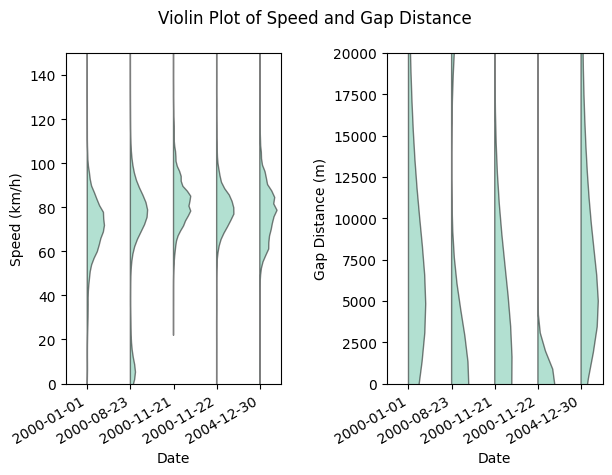

In [196]:
from statsmodels.graphics.boxplots import violinplot

# df = pd.DataFrame(np.random.rand(7, 100), columns=['y']*100)
# df.index = pd.date_range(datetime.today(), periods=7).tolist()
# df
speed_list = []
gap_list = []
for date in date_list:
    speed_list.append(np.array(all_data[all_data['Date']==date]['Speed']))
    gap_list.append(np.array(all_data[all_data['Date']==date]['Gap Distance']))
print(speed_list)
fig, (ax1, ax2) = plt.subplots(1,2)
violinplot(data=speed_list, ax=ax1, labels=date_list, side='right', show_boxplot=False)
violinplot(data=gap_list, ax=ax2, labels=date_list, side='right', show_boxplot=False)
# plt.xlabel('Date')
# plt.ylabel('Speed (km/h)')
plt.setp(ax1, ylim=[0,150], xlabel = 'Date', ylabel = 'Speed (km/h)')
plt.setp(ax2, ylim=[0,20000], xlabel = 'Date', ylabel = 'Gap Distance (m)')
plt.suptitle('Violin Plot of Speed and Gap Distance')
fig.tight_layout()
fig.autofmt_xdate()

## Hourly Vehicular Flow

#### This assumes that all data are measured from the same bridge. Since for different bridges, the number of lanes would affect the expected vehicular flow.

In [271]:
from datetime import time as t
def generate_time(time_list):
    for h in range(24):
        for m in range(60):
            time_list.append(t(h,m).strftime("%H:%M"))
    return


all_data['Time'] = all_data['Date + Time'].dt.round('1min')
all_data['Time'] = all_data['Time'].dt.strftime("%H:%M")
time_list = []
generate_time(time_list)
dict = {"Time": time_list}

print(date_list[0].strftime("%Y-%M-%D"))

for date in date_list:
    vehicle_flow = []
    for time in time_list:
        # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
        vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Time']==time)].index) * 60)

    dict[date] = vehicle_flow
    print(len(vehicle_flow))
# print()
VF_testing = pd.DataFrame(dict)

2000-00-01/01/00
1440
1440
1440
1440
1440


1440


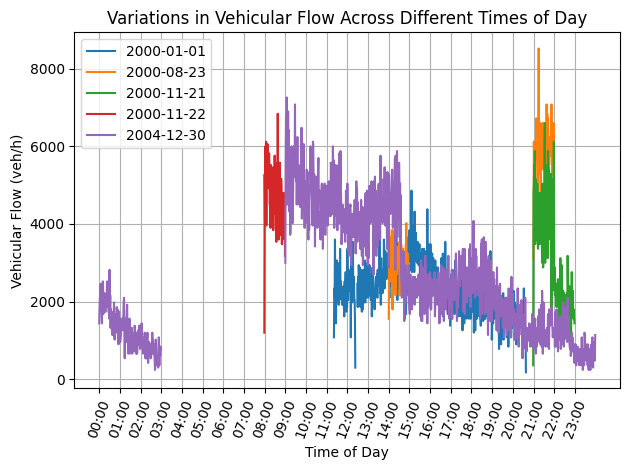

In [276]:
# import numpy as np
# for date in date_list:
#     print(VF_testing[date])
#     VF_testing[VF_testing[date] == 0] = np.nan

# print(hourly_vehicle_flow)
print(len(time_list))
for date in date_list:
    tmp = np.array(VF_testing[date].astype(float))
    tmp[tmp==0] = np.nan
    plt.plot(VF_testing['Time'], tmp, label=date)
    # plt.plot(VF_testing['Time'], VF_testing[date], label=date)
plt.xticks(time_list[::60], rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

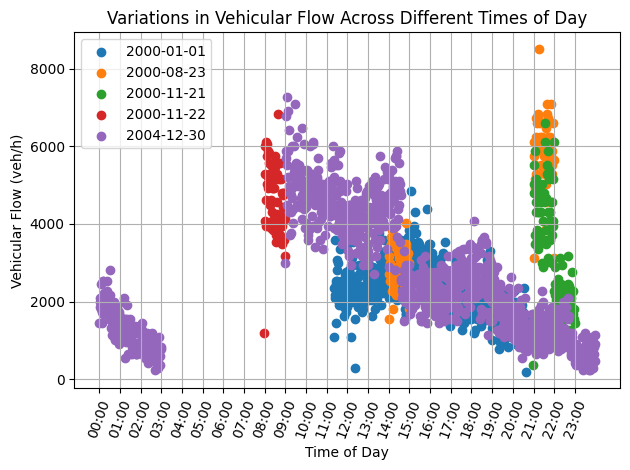

In [277]:
for date in date_list:
    tmp = np.array(VF_testing[date].astype(float))
    tmp[tmp==0] = np.nan
    plt.scatter(VF_testing['Time'], tmp, label=date)
    # plt.plot(VF_testing['Time'], VF_testing[date], label=date)
plt.xticks(time_list[::60], rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

## ABANDONED (LDV : HDV at Varying Times of the Day)

In [311]:
# print(time_list[::60])
dict = {"Time": time_list}

all_data['Hour'] = all_data['Date + Time'].dt.round('1h')
all_data['Hour'] = all_data['Hour'].dt.strftime("%H:%M")


for date in date_list:
    LDV_vehicle_flow = []
    HDV_vehicle_flow = []
    for time in time_list:
        # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
        LDV_vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Hour']==time) & (all_data['Class'].astype(int)<=2)].index) * 60)
        HDV_vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Hour']==time) & (all_data['Class'].astype(int)>2)].index) * 60)

    dict[date.strftime("%Y%M%D") + 'LDV'] = LDV_vehicle_flow
    dict[date.strftime("%Y%M%D") + 'HDV'] = HDV_vehicle_flow

    print(len(vehicle_flow))

    LDV_HDV_testing = pd.DataFrame(dict)

1440
1440
1440
1440
1440


In [312]:
print(LDV_HDV_testing)

       Time  20000001/01/00LDV  20000001/01/00HDV  20000008/23/00LDV   
0     00:00                  0                  0                  0  \
1     00:01                  0                  0                  0   
2     00:02                  0                  0                  0   
3     00:03                  0                  0                  0   
4     00:04                  0                  0                  0   
...     ...                ...                ...                ...   
1435  23:55                  0                  0                  0   
1436  23:56                  0                  0                  0   
1437  23:57                  0                  0                  0   
1438  23:58                  0                  0                  0   
1439  23:59                  0                  0                  0   

      20000008/23/00HDV  20000011/21/00LDV  20000011/21/00HDV   
0                     0                  0                  0  \
1    

7200
7200


TypeError: float() argument must be a string or a number, not 'datetime.time'

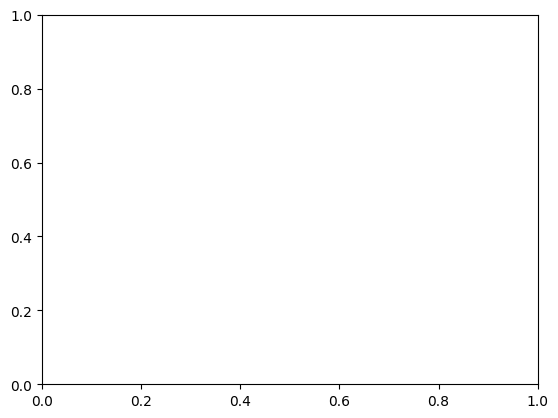

In [328]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import time as t

def generate_time(time_list):
    for h in range(24):
        for m in range(60):
            time_list.append(t(h,m))
    return

total_list = []
time_list = []
generate_time(time_list)

for date in date_list:
    # print(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV'])
    # print(np.array(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV']))
    total_list = np.concatenate((total_list, (np.array(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV']))))
time_list = time_list * len(date_list)

print(len(total_list))
print(len(time_list))

plt.scatter(total_list, time_list, label=date)
plt.xticks(time_list[::60], rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

## LDV to HDV Ratio

In [140]:

# HDV
HDV = all_data.loc[(all_data['Class'].astype(int) > 2)| ((all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) > 6000))]
total_trucks = HDV[HDV.columns[0]].count()
# LDV - Private Vehicle and Motorbikes
PV = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) >= 1500) & (all_data['Total Weight'].astype(int) <= 6000) ]
# PV['Total Weight'].mode
total_cars = PV[PV.columns[0]].count()

# LDV - Motorbike
MB = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) < 1500) ]
total_motorbikes = MB[MB.columns[0]].count()

print([total_trucks,total_cars,total_motorbikes])
print(sum([total_trucks,total_cars,total_motorbikes]))

[32483, 29276, 25743]
87502


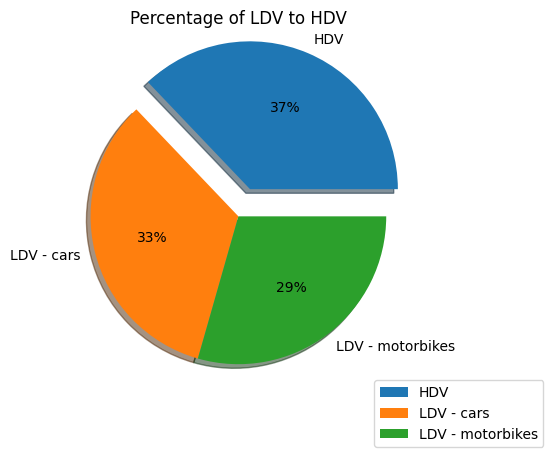

In [141]:
import numpy as np
import matplotlib.pyplot as plt

pie_chart_labels = ['HDV','LDV - cars','LDV - motorbikes']
myexplode = [0.2,0,0]

plt.pie(np.array([total_trucks,total_cars,total_motorbikes]),labels = pie_chart_labels, explode = myexplode, shadow = True, autopct='%1.0f%%')
plt.legend(title = "", bbox_to_anchor=(1,0), loc="lower right", bbox_transform=plt.gcf().transFigure)
plt.title('Percentage of LDV to HDV')
plt.grid()
plt.show()

## Private Vehicle Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

Separating the Private Vehicle from other data

Calculated the Cumulative Probability

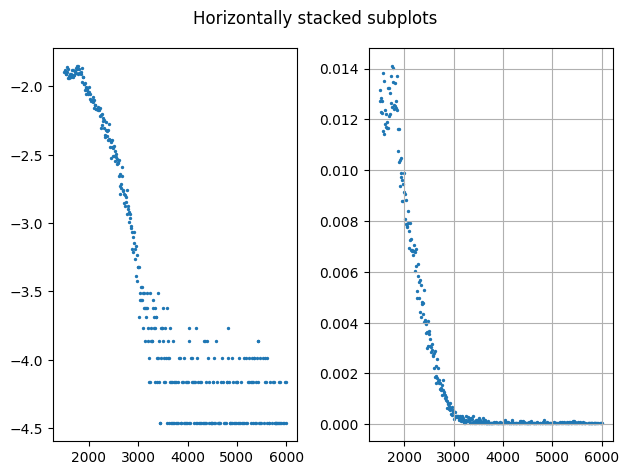

In [267]:
PV_total_weight_and_cumper = pd.DataFrame(PV['Total Weight'].value_counts()).reset_index()
PV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
PV_total_weight_and_cumper['Percentage'] = PV_total_weight_and_cumper['Count'] / total_cars
# Before Sorting
x_data1 = np.log10( PV_total_weight_and_cumper['Total Weight'])
x_data = PV_total_weight_and_cumper['Total Weight']
y_data = PV_total_weight_and_cumper['Percentage']
y_data1 = np.log10(PV_total_weight_and_cumper['Percentage'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax2.scatter(x_data, y_data , s=2)
ax1.scatter(x_data, y_data1 , s=2)
# plt.scatter(x_data, y_data , s=2)
fig.tight_layout()
plt.grid()
plt.show()

# ! Sort
PV_total_weight_and_cumper = PV_total_weight_and_cumper.sort_values('Total Weight')
PV_total_weight_and_cumper['Cumulative Probability'] = PV_total_weight_and_cumper['Percentage'].cumsum()


['Total Weight', 'Count', 'Percentage', 'Cumulative Probability']


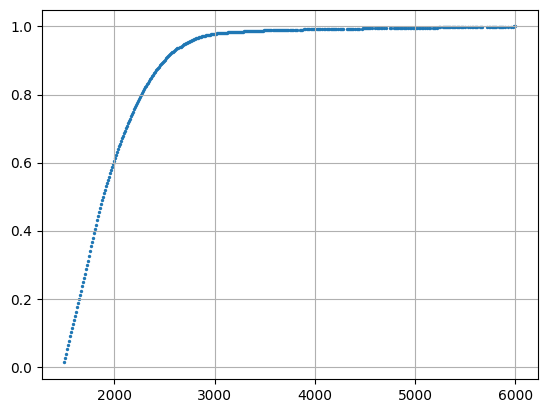

In [143]:
from tensorflow import keras

print(list(PV_total_weight_and_cumper))
x_data = PV_total_weight_and_cumper['Total Weight']
y_data = PV_total_weight_and_cumper['Cumulative Probability']
plt.scatter(x_data, y_data , s=2)
plt.grid()
plt.show()



-0.7194268123491816
[ 8.30471716e-04 -9.53631903e-08]


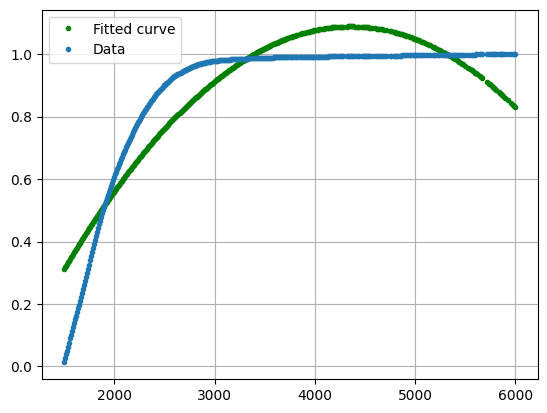

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = PV_total_weight_and_cumper['Total Weight']
y = PV_total_weight_and_cumper['Cumulative Probability']

poly = PolynomialFeatures(degree=2, include_bias=False)
# ! Degree 2 means that the paraeter can be generated as x and x^2
poly_features = poly.fit_transform(np.array(X).reshape(-1,1))

# we do this because polynomial regression is linear
# ! the training dataset and testing dataset are not separated.
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
# predicted from fitted model
y_predicted = poly_reg_model.predict(poly_features)
PV_total_weight_and_cumper['Fitted'] = y_predicted
# FD_data.head()

print(poly_reg_model.intercept_)
print(poly_reg_model.coef_)

# FD_data = FD_data.sort_values(by='k')
## plot the predicted data
plt.plot(X, PV_total_weight_and_cumper['Fitted'], 'g.', label='Fitted curve')
plt.plot(X, PV_total_weight_and_cumper['Cumulative Probability'], '.', label='Data')
plt.legend(loc=0)
# plt.title('q = %.2f + %.2f*k %.2f*k^2'%(
#     poly_reg_model.intercept_[0], poly_reg_model.coef_[0], poly_reg_model.coef_[1]
# ))
plt.grid()


In [145]:
# Create the model 
model = keras.Sequential()
model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
 dense_8 (Dense)             (None, 64)                128       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                

In [146]:
# Training
model.fit( y_data, x_data, epochs=200, verbose=1)

Epoch 1/200
12/12 [==============================] - 0s 1ms/step - loss: 13967933.0000
Epoch 2/200
12/12 [==============================] - 0s 967us/step - loss: 13966341.0000
Epoch 3/200
12/12 [==============================] - 0s 1ms/step - loss: 13959988.0000
Epoch 4/200
12/12 [==============================] - 0s 1ms/step - loss: 13933855.0000
Epoch 5/200
12/12 [==============================] - 0s 962us/step - loss: 13837237.0000
Epoch 6/200
12/12 [==============================] - 0s 939us/step - loss: 13515231.0000
Epoch 7/200
12/12 [==============================] - 0s 962us/step - loss: 12607688.0000
Epoch 8/200
12/12 [==============================] - 0s 990us/step - loss: 10309701.0000
Epoch 9/200
12/12 [==============================] - 0s 3ms/step - loss: 6026065.5000
Epoch 10/200
12/12 [==============================] - 0s 1ms/step - loss: 1770453.5000
Epoch 11/200
12/12 [==============================] - 0s 1ms/step - loss: 1485557.2500
Epoch 12/200
12/12 [==============

KeyboardInterrupt: 

12/12 [==============================] - 0s 702us/step


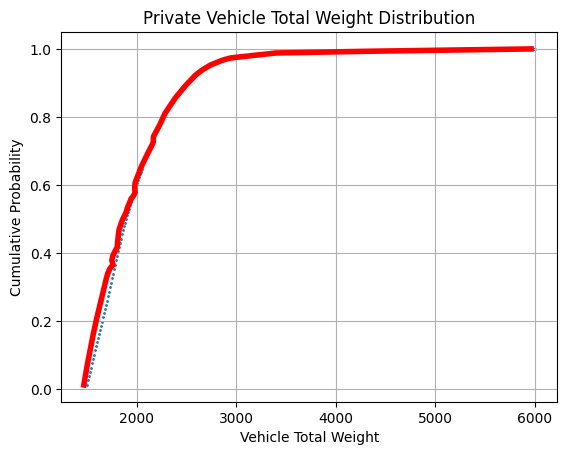

In [ ]:
# Compute the output 
x_predicted = model.predict(y_data)

# Display the result
plt.scatter(x_data[::1], y_data[::1], s=1)
plt.plot(x_predicted, y_data, 'r', linewidth=4)
plt.title('Private Vehicle Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

In [ ]:
total_weight_predicted = model(np.array([0.9999]))
print(total_weight_predicted)

tf.Tensor([[5939.1943]], shape=(1, 1), dtype=float32)


## HDV Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

In [ ]:
HDV_total_weight_and_cumper = pd.DataFrame(HDV['Total Weight'].value_counts()).reset_index()
HDV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
HDV_total_weight_and_cumper['Percentage'] = HDV_total_weight_and_cumper['Count'] / total_trucks
# Sort it by Weight First or it messes up the Cumu Prob
HDV_total_weight_and_cumper = HDV_total_weight_and_cumper.sort_values("Total Weight")
HDV_total_weight_and_cumper['Cumulative Probability'] = HDV_total_weight_and_cumper['Percentage'].cumsum()
HDV_total_weight_and_cumper.tail(30)

,Total Weight,Count,Percentage,Cumulative Probability
4140,66320,1,0.000031,0.999076
4232,66350,1,0.000031,0.999107
4493,66540,1,0.000031,0.999138
4611,66560,1,0.000031,0.999169
4637,66700,1,0.000031,0.999200
4655,66820,1,0.000031,0.999230
3340,66920,2,0.000062,0.999292
4305,67200,1,0.000031,0.999323
3988,67590,1,0.000031,0.999354
4585,67750,1,0.000031,0.999384


['Total Weight', 'Count', 'Percentage', 'Cumulative Probability']


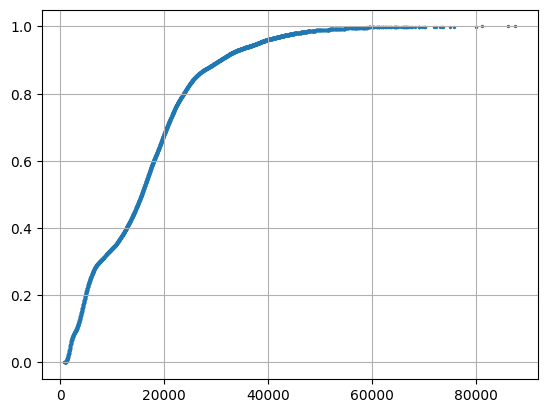

In [ ]:
print(list(HDV_total_weight_and_cumper))
truck_x_data = HDV_total_weight_and_cumper['Total Weight']
truck_y_data = HDV_total_weight_and_cumper['Cumulative Probability']
plt.scatter(truck_x_data, truck_y_data , s=2)
plt.grid()
plt.show()

In [ ]:
# Create the model 
truck_model = keras.Sequential()
truck_model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
truck_model.add(keras.layers.Dense(units = 64, activation = 'relu'))
truck_model.add(keras.layers.Dense(units = 64, activation = 'relu'))
truck_model.add(keras.layers.Dense(units = 64, activation = 'relu'))
truck_model.add(keras.layers.Dense(units = 64, activation = 'relu'))
truck_model.add(keras.layers.Dense(units = 64, activation = 'relu'))
truck_model.add(keras.layers.Dense(units = 1, activation = 'linear'))
truck_model.compile(loss='mse', optimizer="adam")

# Display the truck_model
truck_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1)                 2         
                                                                 
 dense_31 (Dense)            (None, 64)                128       
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dense_36 (Dense)            (None, 1)                

In [ ]:
# Training
model.fit( truck_y_data, truck_x_data, epochs=200, verbose=1)

Epoch 1/200
147/147 [==============================] - 0s 995us/step - loss: 1258041.0000
Epoch 2/200
147/147 [==============================] - 0s 937us/step - loss: 781379.8750
Epoch 3/200
147/147 [==============================] - 0s 929us/step - loss: 970804.1250
Epoch 4/200
147/147 [==============================] - 0s 1ms/step - loss: 1084899.5000
Epoch 5/200
147/147 [==============================] - 0s 988us/step - loss: 988270.8750
Epoch 6/200
147/147 [==============================] - 0s 981us/step - loss: 1754258.3750
Epoch 7/200
147/147 [==============================] - 0s 977us/step - loss: 787443.6875
Epoch 8/200
147/147 [==============================] - 0s 1ms/step - loss: 819315.4375
Epoch 9/200
147/147 [==============================] - 0s 966us/step - loss: 1681390.0000
Epoch 10/200
147/147 [==============================] - 0s 1ms/step - loss: 607080.2500
Epoch 11/200
147/147 [==============================] - 0s 1ms/step - loss: 811854.1875
Epoch 12/200
147/147 [=

147/147 [==============================] - 0s 737us/step


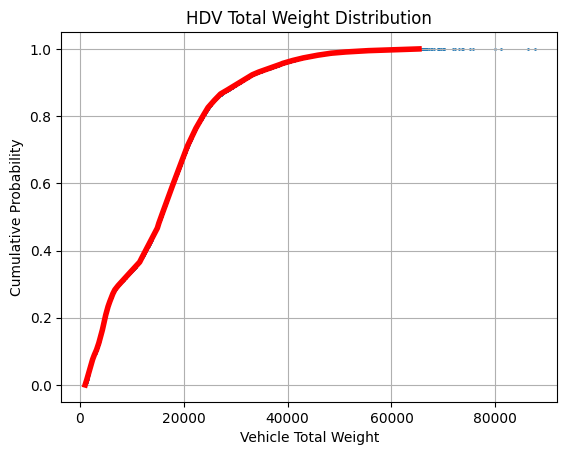

In [ ]:
# Compute the output 
truck_x_predicted = model.predict(truck_y_data)

# Display the result
plt.scatter(truck_x_data[::1], truck_y_data[::1], s=1)
plt.plot(truck_x_predicted, truck_y_data, 'r', linewidth=4)
plt.title('HDV Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

In [ ]:
total_weight_predicted = model(np.array([0.5]))
print(total_weight_predicted)

tf.Tensor([[15643.387]], shape=(1, 1), dtype=float32)
